<a href="https://colab.research.google.com/github/nishantbala/twitter-sentiment-analysis/blob/master/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Predictor**
### **Import the libraries, load dataset, print shape of data, data description**

In [1]:
!pip install contractions
!pip install autocorrect
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import WhitespaceTokenizer           # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from sklearn.metrics import accuracy_score

from autocorrect import Speller

     |████████████████████████████████| 284 kB 5.1 MB/s 
     |████████████████████████████████| 321 kB 35.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85442 sha256=6ca3bfa6542c7657a11f2f7959b9d23e72d4e0293b1e32c281643b28e6e91663
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 622 kB 5.1 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=cea5e12388be555fa60287966d90345a3cb539bf73f28cf7da84d6b8ea1a6179
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zi

In [2]:
import matplotlib.pyplot as plt # To plot the figures
import seaborn as sns # To plot the figures

In [3]:
# load dataset
train = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/train.csv?raw=true')
test = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/test.csv?raw=true')

In [4]:
#print shape

train.shape

(31962, 3)

In [5]:
#train data first 5 data
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
#train data description
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


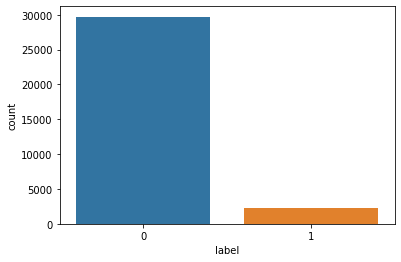

In [7]:
sns.countplot(x = train['label'])

In [8]:
train.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


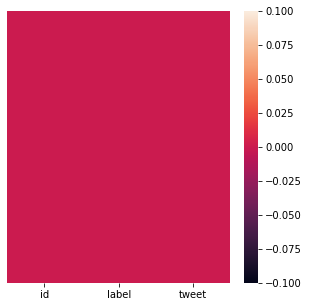

In [9]:
plt.figure(figsize=(5, 5))
sns.heatmap(train.isnull(), yticklabels=False) # Heatmap for visualising null values

## **Data pre-processing**
### Drop all other columns except “tweet” and “label”

In [10]:
trimmed_data = train.copy(deep=True)
for col in train.columns:
  if (col != 'tweet' and col != 'label'):
    trimmed_data.drop([col], axis=1, inplace=True)
trimmed_data.shape
trimmed_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [11]:
def top_words(df_tmp, num_top = 20):    
    words = []
    top_words_df = pd.Series([], dtype= 'object') # creating empty data series
        
    for row in df_tmp.iterrows(): # iterating through rows
        words.append(row[1][1].split())
        
    words = list(np.concatenate(words).flat) # list containg all words
    top_words_df = pd.DataFrame(words).value_counts().rename_axis('words')[:num_top].reset_index(name = 'count')
    return top_words_df

In [12]:
train_data_neutral = trimmed_data.loc[trimmed_data['label'] == 0]
train_data_hate_speech = trimmed_data.loc[trimmed_data['label'] == 1]

In [13]:
train_data_neutral.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [14]:
neutral_train_top = top_words(train_data_neutral)
neutral_train_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,@user,15465
1,the,9249
2,to,9207
3,a,5654
4,i,5455
5,you,4555
6,and,4473
7,for,4196
8,in,4147
9,of,3695


In [15]:
hate_speech_train_top = top_words(train_data_hate_speech)
hate_speech_train_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,@user,1826
1,the,816
2,a,607
3,to,561
4,of,457
5,is,425
6,in,423
7,you,394
8,and,358
9,are,314


In [16]:
# Remove mentions (twitter handle names eg: @user) from the sentence
def remove_mentions(words):
    return " ".join(filter(lambda x:x[0]!='@', words.split()))

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_mentions(x))
trimmed_data.head()

,label,tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation


### Tokenization of tweets

In [17]:
Tokenizer=WhitespaceTokenizer()
trimmed_data['tweet'] = trimmed_data.apply(lambda row: Tokenizer.tokenize(row['tweet']), axis=1)
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, u, take, with, u, all, the, ..."
4,0,"[factsguide:, society, now, #motivation]"


### Replace contractions

In [18]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    new_words = []
    for word in text:
      new_word = contractions.fix(word)
      if new_word != '':
        new_words.append(new_word)
    return new_words

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: replace_contractions(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, cannot, use, b..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, you, take, with, you, all, t..."
4,0,"[factsguide:, society, now, #motivation]"


### Remove punctuations

In [19]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_punctuation(x))        

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Convert to lowercase

In [20]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: to_lowercase(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Stemming

In [21]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: lemmatize_list(x))    
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, be, dysfunctional, and, be, ..."
1,0,"[thank, for, lyft, credit, i, cannot, use, bec..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Remove stop words

In [22]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(words):
    new_words = []
    for word in words:
      if word not in stop_words:
          new_words.append(word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_stopwords(np.array(x)))    
trimmed_data.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drag, kid, dy..."
1,0,"[thank, lyft, credit, cannot, use, do not, off..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time, urð, ðððð, ððð]"
4,0,"[factsguide, society, motivation]"


### Autocorrect for misspelt words

In [23]:
spell = Speller(lang='en')
def autospell(words):
  new_words = []
  for word in words:
      new_word = spell(word)
      new_words.append(new_word)
  return new_words
  
#trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: autospell(x))
#trimmed_data.head()

### Normalize words

In [24]:
def normalize(words):   
    return ' '.join(words)
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: normalize(x))
trimmed_data.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cannot use do not offer whee...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [25]:
trimmed_data_neutral = trimmed_data.loc[trimmed_data['label'] == 0]
trimmed_data_hate_speech = trimmed_data.loc[trimmed_data['label'] == 1]

In [26]:
trimmed_data_neutral.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cannot use do not offer whee...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [27]:
trimmed_data_hate_speech.head()

,label,tweet
13,1,cnn call michigan middle school build wall cha...
14,1,comment australia opkillingbay seashepherd hel...
17,1,retweet agree
23,1,lumpy say prove lumpy
34,1,it is unbelievable 21st century we would need ...


In [28]:
neutral_top = top_words(trimmed_data_neutral)
neutral_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,love,2892
1,ð,2465
2,day,2191
3,is,1771
4,get,1719
5,happy,1651
6,â,1595
7,i,1461
8,not,1446
9,go,1344


In [29]:
hate_speech_top = top_words(trimmed_data_hate_speech)
hate_speech_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,amp,268
1,trump,210
2,â,202
3,not,182
4,is,161
5,white,152
6,libtard,149
7,black,146
8,like,139
9,racist,102


In [30]:
data_for_countVectorizer = trimmed_data.copy(deep=True)
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

ct_vectorizer = CountVectorizer(max_features=2000)                # Keep only 1000 features as number of features will increase the processing time.
cv_data_features = ct_vectorizer.fit_transform(data_for_countVectorizer['tweet'])
cv_data_features = cv_data_features.toarray()                        # Convert the data features to array.
print(cv_data_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [31]:
cv_data_features.shape

(31962, 2000)

In [32]:
labels = data_for_countVectorizer['label']
labels = labels.astype('int')
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64


In [33]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cv_data_features, labels, test_size=0.3, random_state=13)

In [34]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

cv_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

cv_forest = cv_forest.fit(X_train, y_train)

print(cv_forest)

print(np.mean(cross_val_score(cv_forest, cv_data_features, labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.9479379917734201


In [35]:
# Predict the result for test data using the model built above.
cv_result = cv_forest.predict(X_test)
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, cv_result)

print(conf_mat)

[[8730  224]
 [ 297  338]]


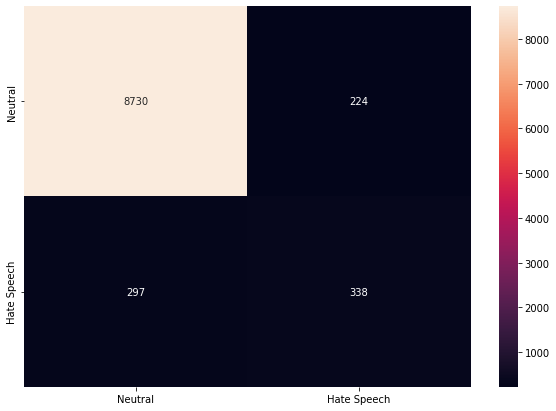

In [36]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [37]:
print('The accuracy score of the predicted model using CountVectorizer is: ', round(accuracy_score(y_test, cv_result),2)) 

The accuracy score of the predicted model using CountVectorizer is:  0.95


In [38]:
# TfidfVectorizer
data_for_TfidfVectorizer = trimmed_data.copy(deep=True)
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

t_vectorizer = TfidfVectorizer(max_features=2000)
tv_data_features = t_vectorizer.fit_transform(data_for_TfidfVectorizer['tweet'])

tv_data_features = tv_data_features.toarray()

tv_data_features.shape

(31962, 2000)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tv_data_features, labels, test_size=0.3, random_state=42)

In [40]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
tv_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
tv_forest = tv_forest.fit(X_train, y_train)
print(tv_forest)
print(np.mean(cross_val_score(tv_forest, tv_data_features, labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.9545709310551234


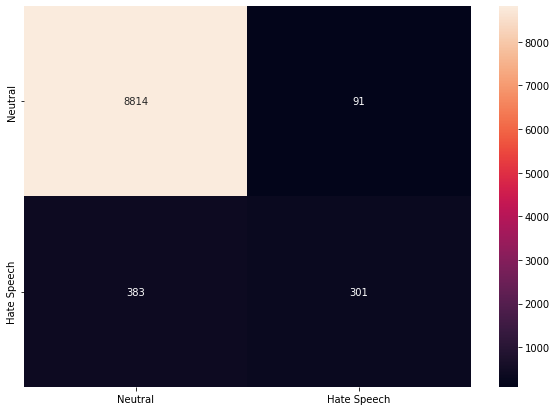

In [41]:
tv_result = tv_forest.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, tv_result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')